In [1]:
from pymongo import MongoClient
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ggplot import *

In [2]:
import pyspark
from pyspark.sql.types import *
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
# Build our Spark Session and Context
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext
spark, sc

(<pyspark.sql.session.SparkSession at 0x7ff733598950>,
 <pyspark.context.SparkContext at 0x7ff7334da910>)

### load utility matrix

In [4]:
# load data frame from csv
data_df = pd.read_csv("../data/model_df.csv", sep='\t')

# drop duplicates
data_df = data_df.drop_duplicates(subset=['route_id', 'user_id'])

y_data = data_df[['route_id', 'user_id','rating']]
x_data = data_df.drop(['rating', 'route_id', 'user_id', 'member_since', 'Unnamed: 0'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, random_state=42)

In [5]:
# Convert to a Spark DataFrame
y_train_spark = spark.createDataFrame(y_train)
y_test_spark = spark.createDataFrame(y_test)

In [6]:
y_train_spark.show()

+--------+-------+------+
|route_id|user_id|rating|
+--------+-------+------+
|     370|    932|     3|
|     988|   1289|     2|
|    1519|    973|     3|
|    2014|   1669|     3|
|    1455|   1923|     4|
|     684|   1094|     2|
|    3609|    399|     2|
|    1497|   1647|     3|
|     982|    658|     3|
|    2091|   1660|     3|
|    3060|   1849|     3|
|    3245|   1017|     3|
|     798|   1148|     2|
|    1512|    917|     3|
|    1519|    641|     3|
|      26|   1134|     3|
|    1280|    472|     2|
|    2014|    614|     2|
|    1688|    218|     2|
|    1200|    925|     4|
+--------+-------+------+
only showing top 20 rows



In [6]:
path = '../data/alsmodel_val'

### save model

In [ ]:
als_model = ALS(userCol='user_id',
                itemCol='route_id',
                ratingCol='rating',
                nonnegative=True,
                regParam=0.1,
                rank=10
               )
recommender = als_model.fit(y_train_spark)

In [ ]:
recommender.save(path)

### load als model

In [7]:
recommender = ALSModel.load(path)

In [8]:
# Make predictions for the whole test set
predictions = recommender.transform(y_test_spark)

In [9]:
# Dump the predictions to Pandas DataFrames to make our final calculations easier
predictions_df = predictions.toPandas()

In [10]:
# Fill any missing values with the mean rating
# There are multiple things you could fill with, this is just one example
predictions_df = predictions.toPandas().fillna(y_train['rating'].mean())

predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['prediction'])**2

# Calculate RMSE
print np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

0.728331695323


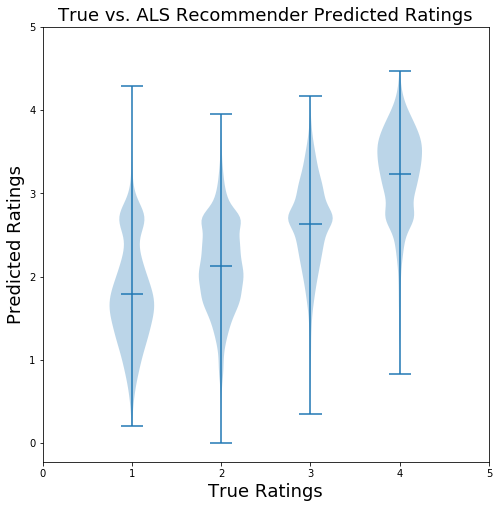

In [11]:
# Create array of predictions for violinplot
data = [predictions_df['prediction'][predictions_df['rating'] == rating] for rating in range(1, 5)]

fig, ax = plt.subplots(1, figsize=(8,8))
ax.violinplot(data, range(1,5), showmeans=True)
ax.set_xlabel('True Ratings', {'fontsize':18})
ax.set_ylabel('Predicted Ratings', {'fontsize':18})
ax.set_title('True vs. ALS Recommender Predicted Ratings', {'fontsize':18})
ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_yticks([0, 1, 2, 3, 4, 5])
plt.show()

fig.savefig('../data/images/violin_als.jpg')

### grab gradient boosting pickle model

In [11]:
from sklearn.externals import joblib
gb = joblib.load('../pickle/gb_model.pkl') 
gb_predict = gb.predict(X_test)

In [11]:
feat_imp = gb.feature_importances_
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : gb.feature_importances_},
                           index=X_test.columns)

In [27]:
feat_scores_lim = feat_scores.sort_values(by='Fraction of Samples Affected', ascending=False).head(10)

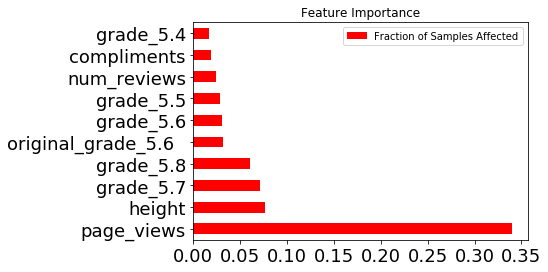

In [37]:
feat_scores_lim.plot(kind='barh', color='red', title= 'Feature Importance', fontsize=18)
plt.savefig('../data/images/gb_features.jpg')

In [13]:
predictions_df['gb_pred'] = gb_predict

In [14]:
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['gb_pred'])**2

# Calculate RMSE
print np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

0.724112522803


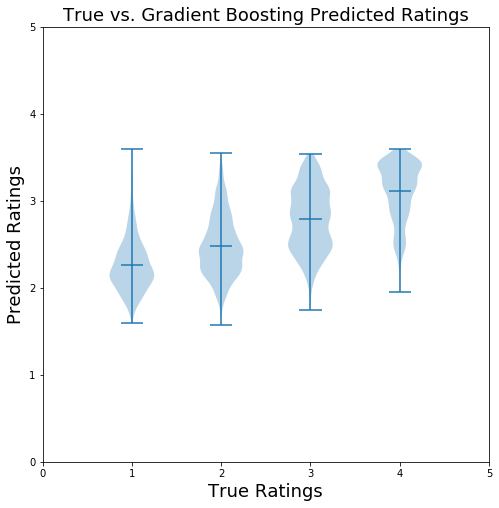

In [15]:
data = [predictions_df['gb_pred'][predictions_df['rating'] == rating] for rating in range(1, 5)]
fig, ax = plt.subplots(1, figsize=(8,8))
ax.violinplot(data, range(1,5), showmeans=True)
ax.set_xlabel('True Ratings', {'fontsize':18})
ax.set_ylabel('Predicted Ratings', {'fontsize':18})
ax.set_title('True vs. Gradient Boosting Predicted Ratings', {'fontsize':18})
ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_yticks([0, 1, 2, 3, 4, 5])
plt.show()

fig.savefig('../data/images/violin_gb.jpg')

### fill nulls with gb model prediction

In [41]:
predictions_df = predictions.toPandas()

In [ ]:
null_ind = pd.isnull(predictions_df).any(1).nonzero()[0]

In [ ]:
predictions_df.ix[null_ind, 'prediction'] = gb_predict[null_ind]

In [ ]:
predictions_df.head(18)

In [ ]:
# Fill any missing values with the mean rating
# There are multiple things you could fill with, this is just one example
predictions_df = predictions.toPandas().fillna(y_train['rating'].mean())

predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['prediction'])**2

# Calculate RMSE
print np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

# Create array of predictions for violinplot
data = [predictions_df['prediction'][predictions_df['rating'] == rating] for rating in range(1, 5)]

fig, ax = plt.subplots(1, figsize=(12,12))
ax.violinplot(data, range(1,5), showmeans=True)
ax.set_xlabel('True Ratings')
ax.set_ylabel('Predicted Ratings')
ax.set_title('True vs. ALS Recommender Predicted Ratings')
plt.show()

In [ ]:
fig.savefig('../data/images/violin_ensemble1.jpg')

### try weighted

In [42]:
predictions_df = predictions.toPandas()
predictions_df = predictions.toPandas().fillna(y_train['rating'].mean())

In [43]:
predictions_df['weighted'] = (0.8 * predictions_df['prediction']) + (0.2 * pd.DataFrame(gb_predict)[0])

In [44]:
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['weighted'])**2

In [45]:
# Calculate RMSE
np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

0.69306253581846633

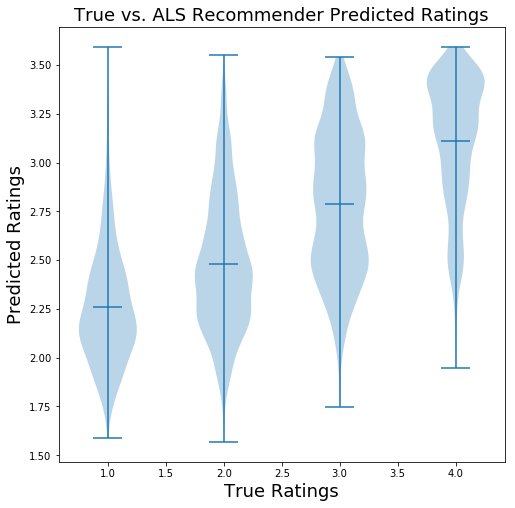

In [47]:
fig, ax = plt.subplots(1, figsize=(8,8))
ax.violinplot(data, range(1,5), showmeans=True)
ax.set_xlabel('True Ratings', {'fontsize':18})
ax.set_ylabel('Predicted Ratings', {'fontsize':18})
ax.set_title('True vs. ALS Recommender Predicted Ratings', {'fontsize':18})
plt.show()

In [ ]:
fig.savefig('../data/images/violin_ensemble2.jpg')

In [ ]:
predictions_df[predictions_df['user_id'] == 560]

### reweight based on num of reviews

In [51]:
#normalized_rating_count = X_test['num_reviews'] / float(X_test['num_reviews'].max())
normalized_rating_count = X_test['page_views'] / float(X_test['page_views'].max())

rmse_list = []
for j in np.linspace(0.0, 1.0, num=100):
    predictions_df['weighted2'] = predictions_df['weighted'] + (j * normalized_rating_count).tolist()
    predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['weighted2'])**2
    # Calculate RMSE
    rmse = np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))
    rmse_list.append(rmse)
    print "rmse: {}, weight: {}".format(rmse, j)

rmse: 0.693062535818, weight: 0.0
rmse: 0.692846113736, weight: 0.010101010101
rmse: 0.69263348288, weight: 0.020202020202
rmse: 0.692424646742, weight: 0.030303030303
rmse: 0.692219608758, weight: 0.040404040404
rmse: 0.692018372302, weight: 0.0505050505051
rmse: 0.691820940693, weight: 0.0606060606061
rmse: 0.691627317189, weight: 0.0707070707071
rmse: 0.691437504988, weight: 0.0808080808081
rmse: 0.691251507232, weight: 0.0909090909091
rmse: 0.691069326999, weight: 0.10101010101
rmse: 0.690890967309, weight: 0.111111111111
rmse: 0.690716431123, weight: 0.121212121212
rmse: 0.690545721339, weight: 0.131313131313
rmse: 0.690378840796, weight: 0.141414141414
rmse: 0.690215792271, weight: 0.151515151515
rmse: 0.69005657848, weight: 0.161616161616
rmse: 0.68990120208, weight: 0.171717171717
rmse: 0.689749665662, weight: 0.181818181818
rmse: 0.689601971758, weight: 0.191919191919
rmse: 0.689458122838, weight: 0.20202020202
rmse: 0.689318121309, weight: 0.212121212121
rmse: 0.689181969516,

In [ ]:
min(rmse_list)

In [50]:
min(rmse_list)

0.68522207561345672

In [ ]:
min_rmse_ind = rmse_list.index(min(rmse_list))

In [ ]:
weight = np.linspace(0.0, 1.0, num=100)[min_rmse_ind]

In [ ]:
weight

In [ ]:
predictions_df['weighted2'] = predictions_df['weighted'] + (weight * normalized_rating_count).tolist()
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['weighted2'])**2
print "RMSE:", np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

### find user predictions

In [ ]:
data = pd.DataFrame(columns=['route_id', 'user_id'])
data['user_id'] = (0 * y_data['route_id']) + 560 
data['route_id'] = y_data['route_id']
one_row_spark_df = spark.createDataFrame(data)
# Get the recommender's prediction
recs = recommender.transform(one_row_spark_df)
recs.show()

In [ ]:
recs_df = recs.toPandas().drop_duplicates(subset='route_id')
recs_df.sort_values('prediction', ascending=False).head(6)

### Try reweighting

In [ ]:
df = data_df.drop_duplicates(subset=['route_id'])

In [ ]:
df = df.reset_index().drop('index', axis=1)

In [ ]:
df['route_id'].tolist() == recs_df['route_id'].tolist()

In [ ]:
recs_df = recs_df.reset_index().drop('index', axis=1)

In [ ]:
normalized_rating_count = df['num_reviews'] / float(df['num_reviews'].max())

In [ ]:
recs_df['new_pred'] = recs_df['prediction'] + (normalized_rating_count * 0.5)

In [ ]:
recs_df.sort_values('new_pred', ascending=False).head(6)

### Add item-by-item matrix

In [12]:
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

# load data frame from csv
routes_df = pd.read_csv("../data/routes_df.csv", sep='\t').drop('Unnamed: 0', axis=1)
routes_df.head()

,id,Aid,Alpine,Boulder,Ice,Mixed,Sport,TR,Trad,height,...,area_World WallaAreas,area_Write-off RockaAreas,area_Wu Wei WallaAreas,area_Wu-Tang WallaAreas,area_XY Crag (Chromosome Cracks)aAreas,area_Zappa WallaAreas,area_Zeke's Trail BouldersaAreas,area_Zeke's WallaAreas,area_Zig Zag WallaAreas,num_reviews
0,0,0,0,0,0,0,0,0,1,41.0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,1,41.0,...,0,0,0,0,0,0,0,0,0,1
2,2,0,0,0,0,0,0,1,1,35.0,...,0,0,0,0,0,0,0,0,0,4
3,3,0,0,0,0,0,0,1,1,85.0,...,0,0,0,0,0,0,0,0,0,4
4,4,0,0,0,0,0,0,1,1,30.0,...,0,0,0,0,0,0,0,0,0,4


In [13]:
routes_id = routes_df['id']
routes_df = routes_df.drop('id', axis=1)

In [14]:
items_mat = np.array(list(routes_df.values)).astype(float)

In [15]:
items_mat_norm = normalize(items_mat)
cos_sim = 1-pairwise_distances(items_mat, metric="cosine")

### What is the RMSE for item-by-item?

In [16]:
item_by_item_pred = [] 
n = 5
for _id in y_test['route_id']:
    # find the similar routes
    index = routes_id[routes_id == _id].index.tolist()[0]
    arr = cos_sim[index]
    similar_routes = np.asarray(routes_id)[arr.argsort()[-(n+1):][::-1][1:]]
    # average the five routes together to get rating
    pred = y_train[y_train['route_id'].isin(similar_routes)]['rating']
    mean_rating = pred.mean()
    item_by_item_pred.append(mean_rating) 

In [17]:
predictions_df['item_by_item_pred'] = pd.Series(item_by_item_pred)
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['item_by_item_pred'])**2
np.sqrt(sum(predictions_df['rating'] - predictions_df['squared_error']) / len(predictions_df))

1.3966725260592467

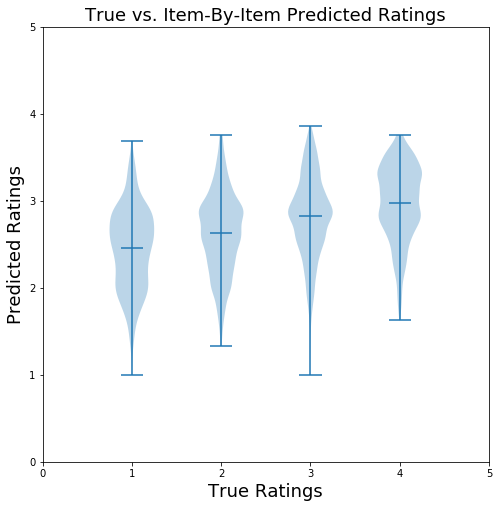

In [23]:
# Create array of predictions for violinplot
data = [predictions_df['item_by_item_pred'][predictions_df['rating'] == rating] for rating in range(1, 5)]

fig, ax = plt.subplots(1, figsize=(8,8))
ax.violinplot(data, range(1,5), showmeans=True)
ax.set_xlabel('True Ratings', {'fontsize':18})
ax.set_ylabel('Predicted Ratings', {'fontsize':18})
ax.set_title('True vs. Item-By-Item Predicted Ratings', {'fontsize':18})
ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_yticks([0, 1, 2, 3, 4, 5])
plt.show()

fig.savefig('../data/images/violin_item_by_item.jpg')

In [18]:
# fill nulls with item_by item value
predictions_df = predictions.toPandas()
null_ind = pd.isnull(predictions_df).any(1).nonzero()[0]
predictions_df.ix[null_ind, 'prediction'] = np.array(item_by_item_pred)[null_ind]

0.721367517146


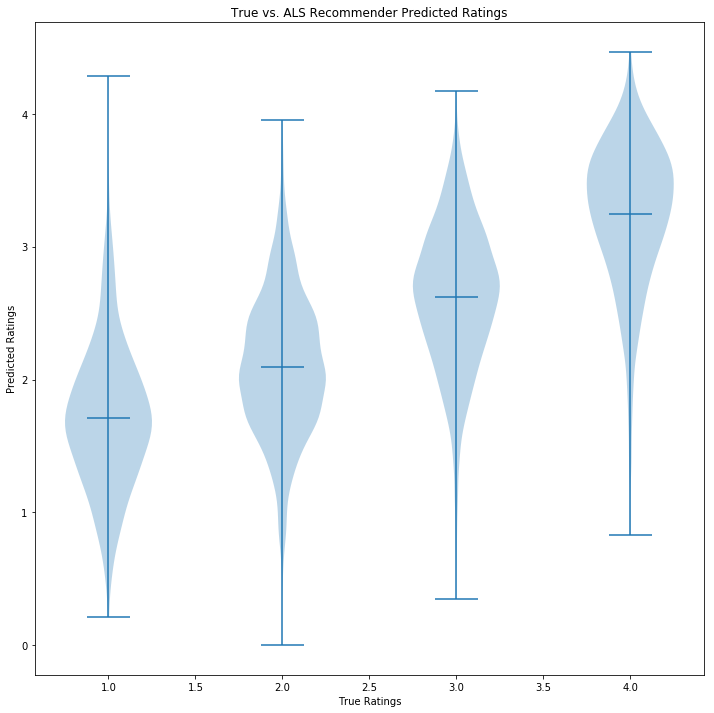

In [21]:
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['prediction'])**2

# Calculate RMSE
print np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

# Create array of predictions for violinplot
data = [predictions_df['prediction'][predictions_df['rating'] == rating] for rating in range(1, 5)]

fig, ax = plt.subplots(1, figsize=(12,12))
ax.violinplot(data, range(1,5), showmeans=True)
ax.set_xlabel('True Ratings')
ax.set_ylabel('Predicted Ratings')
ax.set_title('True vs. ALS Recommender Predicted Ratings')
plt.show()

In [ ]:
fig.savefig('../data/images/violin_item_by_item_ensemble.jpg')

### add weighted values to item-by-item matrix

In [19]:
normalized_rating_count = X_test['num_reviews'] / float(X_test['num_reviews'].max())

In [20]:
rmse_list = []
for c in np.linspace(100.0,110.0, 100):
    alpha = np.array((2.0 / (1 + np.exp(-c * normalized_rating_count))) - 1)
    predictions_df['weighted'] = alpha *  predictions_df['prediction'] + (1 - alpha) * item_by_item_pred
    predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['weighted'])**2
    # Calculate RMSE
    rmse = np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))
    rmse_list.append(rmse)

In [21]:
c = np.linspace(100.0,110.0, 100)[rmse_list.index(min(rmse_list))]

In [22]:
alpha = np.array((2.0 / (1 + np.exp(-c * normalized_rating_count))) - 1)
predictions_df['weighted'] = alpha *  predictions_df['prediction'] + (1 - alpha) * item_by_item_pred
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['weighted'])**2
# Calculate RMSE
print np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

0.705084354077


### let's try all three methods

In [24]:
# fill nulls with item_by item value
rmse_list = []
beta_list = []
for beta in np.linspace(0.0, 1.0, 100):
    predictions_df = predictions.toPandas()
    null_ind = pd.isnull(predictions_df).any(1).nonzero()[0]
    predictions_df.ix[null_ind, 'prediction'] = np.array(item_by_item_pred)[null_ind]
    predictions_df['weighted'] = alpha *  predictions_df['prediction'] + (1 - alpha) * item_by_item_pred
    predictions_df['weighted2'] = (beta * predictions_df['weighted']) + ((1 - beta) * pd.DataFrame(gb_predict)[0])
    predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['weighted2'])**2
    rmse = np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))
    rmse_list.append(rmse)
    beta_list.append(beta)


In [30]:
min(rmse_list)

0.67029441222649877

In [26]:
beta = beta_list[rmse_list.index(min(rmse_list))]
predictions_df['weighted2'] = (beta * predictions_df['weighted']) + ((1 - beta) * pd.DataFrame(gb_predict)[0])
top_pred_df = predictions_df[predictions_df['ratings'] > 3.5]

0.55555555555555558

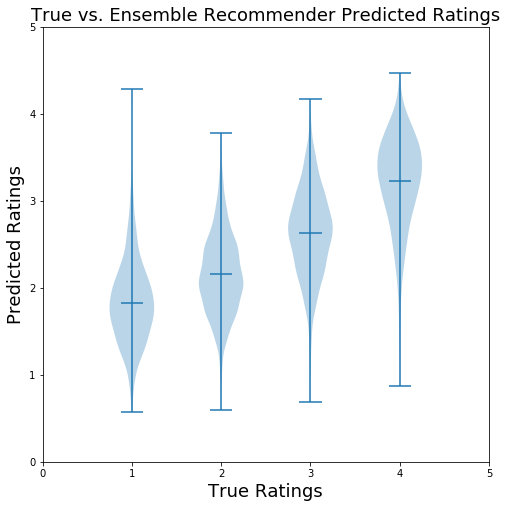

In [32]:
data = [predictions_df['weighted2'][predictions_df['rating'] == rating] for rating in range(1, 5)]

fig, ax = plt.subplots(1, figsize=(8,8))
ax.violinplot(data, range(1,5), showmeans=True)
ax.set_xlabel('True Ratings', {'fontsize':18})
ax.set_ylabel('Predicted Ratings', {'fontsize':18})
ax.set_title('True vs. Ensemble Recommender Predicted Ratings', {'fontsize':18})
ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_yticks([0, 1, 2, 3, 4, 5])
plt.show()

fig.savefig('../data/images/violin_ensemble.jpg')